From: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# How to Create an ARIMA Model for Time Series Forecasting


A popular and widely used statistical method for time series forecasting is the ARIMA model.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

In this tutorial, you will discover how to develop an ARIMA model for time series forecasting in Python.

After completing this tutorial, you will know:

 - About the ARIMA model the parameters used and assumptions made by the model.
 - How to fit an ARIMA model to data and use it to make forecasts.
 - How to configure the ARIMA model on your time series problem.



## Autoregressive Integrated Moving Average Model

An [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

 - **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
 - **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
 - **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

 - **p**: The number of lag observations included in the model, also called the lag order.
 - **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
 - **q**: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

Next, let’s take a look at how we can use the ARIMA model in Python. We will start with loading a simple univariate time series.


## Shampoo Sales Dataset

This dataset describes the monthly number of sales of shampoo over a 3 year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

 - [Download the dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv).

Download the dataset and place it in your current working directory with the filename “shampoo-sales.csv“.

Below is an example of loading the Shampoo Sales dataset with Pandas with a custom function to parse the date-time field. The dataset is baselined in an arbitrary year, in this case 1900.

<ipython-input-1-0408652aa3c9>:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


            Sales
Month            
1901-01-01  266.0
1901-02-01  145.9
1901-03-01  183.1
1901-04-01  119.3
1901-05-01  180.3


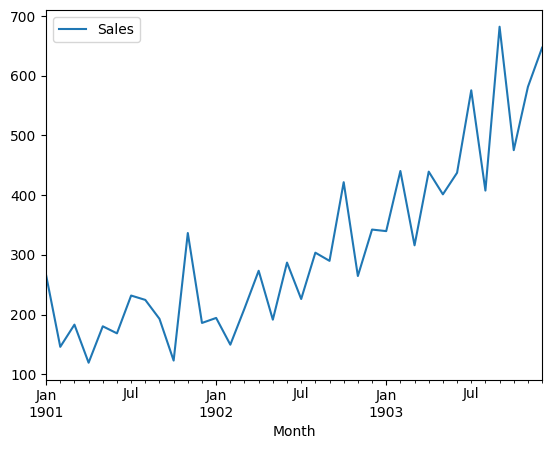

In [1]:
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
print(series.head())
series.plot()
plt.show();

We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas.

In [2]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

sacf = acf(series.values)
spacf = pacf(series.values, method='ols')

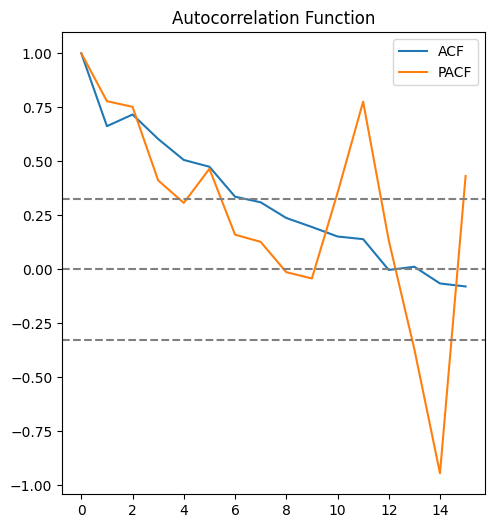

In [3]:
#Plot ACF & PACF:
p = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(sacf,label='ACF')
plt.plot(spacf,label='PACF')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series.values)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series.values)),linestyle='--',color='gray')
plt.legend()
plt.title('Autocorrelation Function');

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags. And a similar behavior with 4 lags is visible for the PACF.

A good starting point for the MA and AR parametera of the model may be 4 and 5.

## ARIMA with Python

The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

1. Define the model by calling [ARIMA()](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMA.html) and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the [fit()](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMA.fit.html) function.
3. Predictions can be made by calling the [predict()](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMA.predict.html) function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

First, we fit an ARIMA(5,1,4) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 4.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -191.879
Date:                Fri, 19 Apr 2024   AIC                            403.759
Time:                        09:38:33   BIC                            419.312
Sample:                    01-01-1901   HQIC                           409.128
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2447      0.306     -0.800      0.424      -0.844       0.355
ar.L2          0.4413      0.289      1.529      0.126      -0.124       1.007
ar.L3         -0.2858      0.260     -1.099      0.2

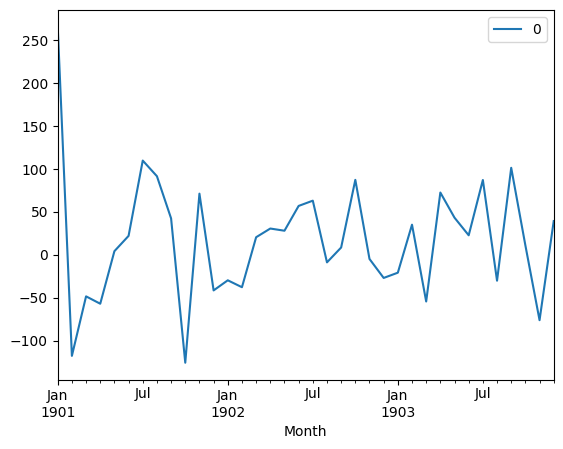

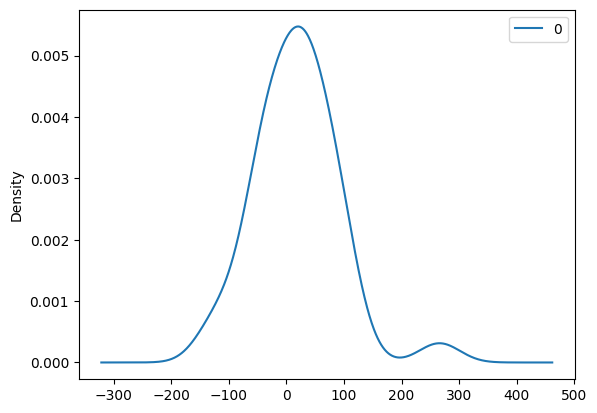

                0
count   36.000000
mean    17.623661
std     72.377102
min   -125.888252
25%    -29.866167
50%     21.263699
75%     58.520079
max    266.000000


In [4]:
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as pyplot

# fit model
model = ARIMA(series, order=(5,1,4))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

Running the example prints a summary of the fit model. This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

Next, let’s look at how we can use the ARIMA model to make forecasts.


## Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the [ARIMAResults](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.html) object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-5-cfafced5d9bd>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat

predicted=382.304508, expected=342.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=320.290547, expected=339.700000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=405.414955, expected=440.400000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=326.365126, expected=315.900000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=346.021577, expected=439.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=314.580830, expected=401.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=469.485450, expected=437.400000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=394.165054, expected=575.500000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=457.289331, expected=407.600000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=569.905362, expected=682.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=448.841397, expected=475.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=678.598448, expected=581.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=602.471905, expected=646.900000
Test MSE: 6201.432


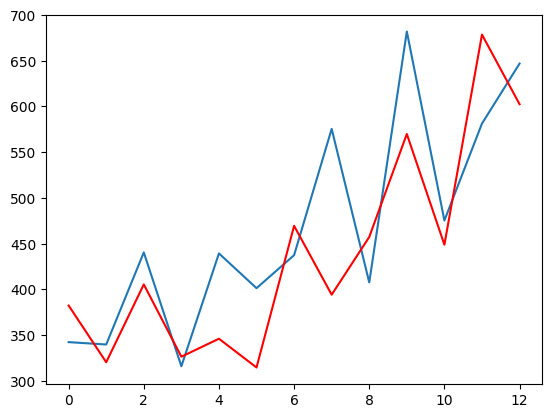

In [5]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,4))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example prints the prediction and expected value each iteration.

We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

The model could use further tuning of the p, d, and maybe even the q parameters.

## Configuring an ARIMA Model

The classical approach for fitting an ARIMA model is to follow the [Box-Jenkins Methodology](https://en.wikipedia.org/wiki/Box–Jenkins_method).

This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

In summary, the steps of this process are as follows:

1. **Model Identification**. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.

2. **Parameter Estimation**. Use a fitting procedure to find the coefficients of the regression model.

3. **Model Checking**. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.

The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).
